In [1]:
# License: BSD
# Adapted from Sasank Chilamkurthy pytorch tutorial for image classification.
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../StateFarmDistractedDriverDetection/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
print(dataset_sizes)
class_names = image_datasets['train'].classes

{'train': 20021, 'val': 2403}


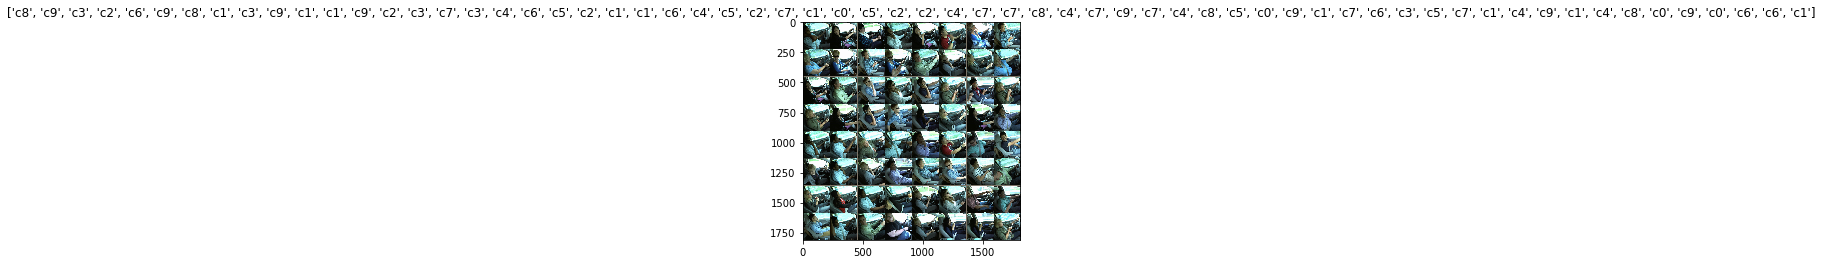

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
# Define the neural network used
#model_ft = models.alexnet(pretrained =True)
model_ft = models.resnet18(pretrained= True)
#model_ft = models.vgg16(pretrained = True)

In [5]:
print (model_ft.parameters)

<bound method ResNet.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

## Use the following for AlexNet
net = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )
model_ft.classifier = net

## Use the following for VGG-16
net = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
        )
model_ft.classifier = net

In [6]:
# Freeze all layers except for the final fully connected layer.
for param in model_ft.parameters():
    param.requires_grad = False

## Use the following for AlexNet
### Replace the final layer to classify into one of 10 classes.
net2 = nn.Linear(4096, 10)
model_ft.classifier.add_module('classify',net2)

In [7]:
## Use the following for Resnet18
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

## Use this for VGG-16 
### Replace the final layer to classify into one of 10 classes.
net2 = nn.Linear(4096, 10)
model_ft.classifier.add_module('classify',net2)


In [8]:
if torch.cuda.is_available():
    model_ft = model_ft.cuda()
    print ("Transfer model to GPU")

Transfer model to GPU


In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
# Use this for AlexNet
#optimizer = optim.SGD(model_ft.classifier.classify.parameters(),lr=0.001, momentum=0.9)

# Use this for Resnet18
optimizer = optim.SGD(model_ft.fc.parameters(),lr=0.001, momentum=0.9)

# Use this for VGG16
#optimizer = optim.SGD(model_ft.classifier.classify.parameters(),lr=0.001, momentum=0.9)

# Can add other args such as weight decay etc.

In [11]:
import math

In [12]:
batch_size = 64
NB = math.ceil(len(image_datasets['train']) /batch_size) 
NB = int(NB)
print (NB)

313


In [13]:
import torch.autograd as ag

In [14]:
import time

In [15]:
num_epochs = 50
accu_test = 0.0
train_accu = 0.0
Time=[]
testaccu = []
trainloss = []

In [16]:
for epoch in range(num_epochs):
    train_loss = 0.0
    running_loss = 0.0
    train_accu = 0.0
    correct = 0
    # Set model to training mode
    model_ft.train()
    t0 = time.time()   
    for i,(inputs,classes) in enumerate(dataloaders['train'],0):
        
        # Obtain a batch of training data
        inputs = inputs.cuda()
        classes = classes.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward
        inputs = ag.Variable(inputs,requires_grad=True)
        classes = ag.Variable(classes, requires_grad =False)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        # Error evaluation
        loss = criterion(outputs,classes)
        
        # Back Propagation
        loss.backward()
        
        # Parameter update
        optimizer.step()
        
        # Print train loss per epoch
        running_loss += loss[0]
        if i%313 == 312:
            print ('[%d] train loss: %.3f'% (epoch+1, np.mean(running_loss.cpu().data.numpy())))
        trainloss.append(np.mean(running_loss.cpu().data.numpy()))
#         print ('Epoch:{},Train Loss is:{}'.format(epoch,train_loss))
        running_loss = 0.0
    
    
# Run trained model on test data
    for i,(inputs,classes) in enumerate(dataloaders['val'],0):
        inputs = inputs.cuda()
        classes = classes.cuda()
        inputs = ag.Variable(inputs,requires_grad=True)
        classes = ag.Variable(classes, requires_grad =False)
        outputs = model_ft(inputs)
    
    # Calculate Accuracy
        outputs_np = outputs.cpu().data.numpy().T.argmax(axis=0)
        classes_np = classes.cpu().data.numpy()
    
        correct += np.mean(np.equal(classes_np,outputs_np))
    testaccu.append(correct/len(dataloaders['val'])*100)
    print ('[%d] testaccu %.3f'% (epoch+1, correct/len(dataloaders['val'])*100))
#         print (correct/len(dataloaders['val'])*100) 
    print('{} seconds'.format(time.time() - t0))
    Time.append(time.time() - t0)
print ("Finished Training")
    

[1] loss: 1.286
[1] testaccu 73.973
75.0651540756 seconds
[2] loss: 0.928
[2] testaccu 81.703
76.7820100784 seconds
[3] loss: 0.645
[3] testaccu 84.287
77.1738200188 seconds
[4] loss: 0.572
[4] testaccu 85.219
75.1949341297 seconds
[5] loss: 0.460
[5] testaccu 86.261
76.6608130932 seconds
[6] loss: 0.453
[6] testaccu 87.843
76.608520031 seconds
[7] loss: 0.359
[7] testaccu 88.049
78.3861041069 seconds
[8] loss: 0.378
[8] testaccu 89.282
73.160823822 seconds
[9] loss: 0.391
[9] testaccu 89.790
77.0179381371 seconds
[10] loss: 0.434
[10] testaccu 90.098
76.4047541618 seconds
[11] loss: 0.430
[11] testaccu 90.489
76.7398378849 seconds
[12] loss: 0.370
[12] testaccu 90.441
75.6949939728 seconds
[13] loss: 0.422
[13] testaccu 91.386
78.4330019951 seconds
[14] loss: 0.337
[14] testaccu 91.660
77.8967080116 seconds
[15] loss: 0.290
[15] testaccu 91.626
75.8064928055 seconds
[16] loss: 0.262
[16] testaccu 92.236
78.1261680126 seconds
[17] loss: 0.277
[17] testaccu 91.881
77.4749150276 seconds


In [17]:
data_array_1 = np.array(Time)
data_array_2 = np.array(testaccu)
data_array_3 = np.array(trainloss)
# saving...
np.savetxt('time_ResNet.csv',data_array_1,delimiter=',')
np.savetxt('testaccu_ResNet.csv',data_array_2,delimiter=',')
np.savetxt('trainloss_ResNet.csv',data_array_3,delimiter=',')
print ('Finish saving csv file')

Finish saving csv file


correct = 0
# Run trained model on test data
for i,(inputs,classes) in enumerate(dataloaders['val'],0):
    inputs = inputs.cuda()
    classes = classes.cuda()
    inputs = ag.Variable(inputs,requires_grad=True)
    classes = ag.Variable(classes, requires_grad =False)
    outputs = model_ft(inputs)
    
    # Calculate Accuracy
    outputs_np = outputs.cpu().data.numpy().T.argmax(axis=0)
    classes_np = classes.cpu().data.numpy()
    
    correct += np.mean(np.equal(classes_np,outputs_np))
print (correct/len(dataloaders['val'])*100)   

In [18]:
# AlexNet accuracy is 62.701053799223516%
# Resnet accuracy is 80.54631170271769
# Vgg16 accuracy is 77.60676650027732